In [1]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch.nn.functional as F

class SinActivation(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)

class KANLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True,
                 base_activation=SinActivation, grid_eps=0.02, grid_range=[-1, 1]):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))

        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(self.grid.T[self.spline_order:-self.spline_order], noise)
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        x = x.unsqueeze(-1)
        grid = self.grid
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k+1)]) / (grid[:, k:-1] - grid[:, :-(k+1)]) * bases[:, :, :-1] +
                     (grid[:, k+1:] - x) / (grid[:, k+1:] - grid[:, 1:-k]) * bases[:, :, 1:])
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        return solution.permute(2, 0, 1).contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1)
        )
        output = base_output + spline_output
        return output.reshape(*original_shape[:-1], self.out_features)


class KAN(torch.nn.Module):
    def __init__(self, layers_hidden, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 base_activation=SinActivation, grid_eps=0.02, grid_range=[-1, 1]):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for in_f, out_f in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(KANLinear(in_f, out_f, grid_size, spline_order, scale_noise,
                                         scale_base, scale_spline, True,
                                         base_activation, grid_eps, grid_range))

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

In [15]:
#initializing the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

#initializing the model, optimizer and scheduler as specified in the paper
model = KAN([1,8,6,8,1]).to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=20000, gamma=0.1)

#training data
N=800
x_train = torch.linspace(0,1,N,requires_grad = True).view(-1,1).to(device)
x_bc1 = torch.tensor([[0.0]], requires_grad=True).to(device)
y_bc1 = torch.tensor([[0.1]], requires_grad=True).to(device)
x_bc2 = torch.tensor([[0.0]], requires_grad=True).to(device)
dydx_bc = torch.tensor([[40.0]], requires_grad=True).to(device)

#training loop
epochs = 40000
w=25
loss_history = []

for epoch in range(epochs):

  optimizer.zero_grad()
  y_pred = model(x_train)
  y_bc1_pred = model(x_bc1)
  dydx_bc_pred = torch.autograd.grad(y_bc1_pred, x_bc1, grad_outputs=torch.ones_like(y_bc1_pred), create_graph=True)[0]

  dydx = torch.autograd.grad(y_pred, x_train, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
  d2ydx2 = torch.autograd.grad(dydx, x_train, grad_outputs=torch.ones_like(dydx), create_graph=True, retain_graph=True)[0]

  residual = d2ydx2 + (w**2)*torch.sin(y_pred)
  physics_loss = (residual**2).mean()

  bc1_loss = (y_bc1_pred - y_bc1).pow(2).mean()
  bc2_loss = (dydx_bc_pred - dydx_bc).pow(2).mean()

  loss = physics_loss + bc1_loss + bc2_loss
  loss_history.append(loss.item())

  loss.backward()
  optimizer.step()
  scheduler.step()

  if epoch%1000==0:
    print(epoch,"---> loss :", loss.item())

True
Tesla T4
0 ---> loss : 3653.17431640625
1000 ---> loss : 1203.2938232421875
2000 ---> loss : 1003.591064453125
3000 ---> loss : 123.86149597167969
4000 ---> loss : 66.53174591064453
5000 ---> loss : 48.90428924560547
6000 ---> loss : 25.564434051513672
7000 ---> loss : 18.666454315185547
8000 ---> loss : 15.047262191772461
9000 ---> loss : 11.754983901977539
10000 ---> loss : 10.297991752624512
11000 ---> loss : 9.363446235656738
12000 ---> loss : 8.137383460998535
13000 ---> loss : 9.553266525268555
14000 ---> loss : 6.74099063873291
15000 ---> loss : 6.737903594970703
16000 ---> loss : 6.804172992706299
17000 ---> loss : 5.684865951538086
18000 ---> loss : 5.449288368225098
19000 ---> loss : 4.988650321960449
20000 ---> loss : 5.075456619262695
21000 ---> loss : 4.715871810913086
22000 ---> loss : 4.681232452392578
23000 ---> loss : 4.628359317779541
24000 ---> loss : 4.55329704284668
25000 ---> loss : 4.478707313537598
26000 ---> loss : 4.34842586517334
27000 ---> loss : 4.2497

In [16]:
#finding the exact solution of the given non linear pendulum equation
#since you can't find the solution by hand through normal methods, you convert the second order ODE to a system of first order ODE
from scipy.integrate import solve_ivp
import numpy as np


# Parameters
w0 = 25
y0 = 0.1      # Initial position y(0)
v0 = 40       # Initial velocity y'(0)
t_span = (0, 1)
t_eval = np.linspace(0, 1, 200)  # 200 time points in [0, 1]

# Define the system of first-order ODEs
def pendulum(t, y):
    return [y[1], -w0**2 * np.sin(y[0])]

#y[0] is the first variable, the position variable
#y[1] is the second variable, the velocity variable
#so the above system of equation returned by the function is equivalent to
#dy1/dt = y2, dy2/dt = -w^2(siny1)


# Solve the ODE
sol = solve_ivp(pendulum, t_span, [y0, v0], t_eval=t_eval)

# Extract the time and solution
t = sol.t
y_exact = sol.y[0]


In [17]:
#model evaluation
model.eval()
x_test = torch.linspace(0,1,200).view(-1,1).to(device)
y_test = model(x_test).detach().cpu().numpy()
x_test = x_test.cpu().numpy()



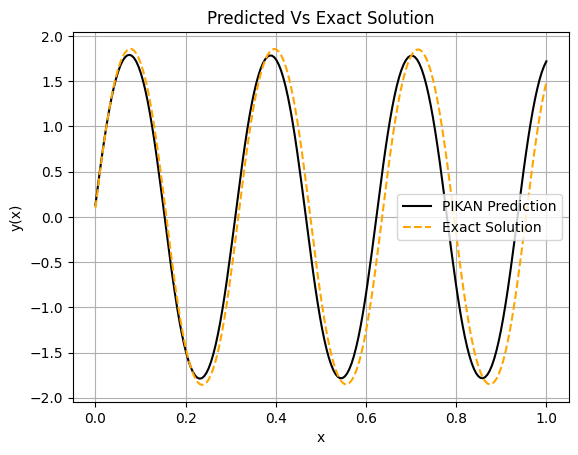

In [18]:
#plot1 - Predicted Vs Exact Solution
plt.plot(x_test, y_test, label="PIKAN Prediction", color='black')
plt.plot(t, y_exact, label="Exact Solution", linestyle='dashed', color='orange')
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Predicted Vs Exact Solution")
plt.legend()
plt.grid(True)
plt.show()

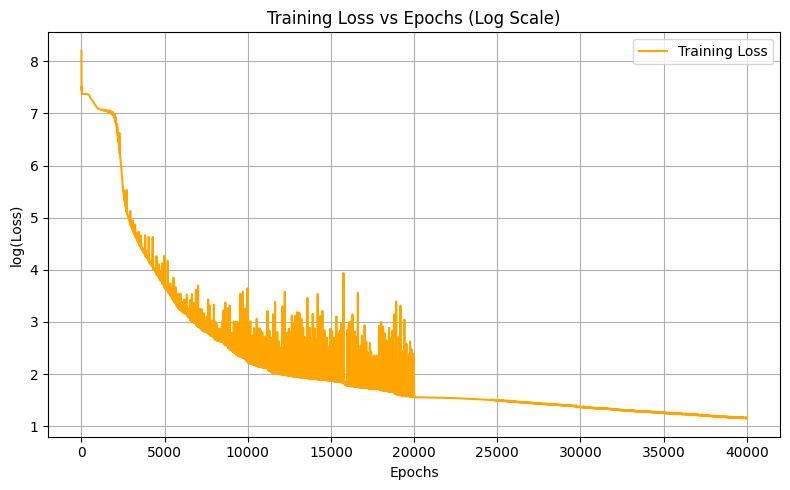

In [19]:
#plot2 - log loss
log_loss = [math.log(l) for l in loss_history]
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), log_loss, label='Training Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('log(Loss)')
plt.title('Training Loss vs Epochs (Log Scale)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
